In [6]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import pandas as pd

In [8]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [9]:
pip install sqlalchemy==1.3

Note: you may need to restart the kernel to use updated packages.


In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [11]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [16]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [17]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [18]:
columns = inspector.get_columns('station')
for cl in columns:
    print(cl['name'], cl['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

# Exploratory Precipitation Analysis

In [20]:
# Find the most recent date in the data set.
last_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last_data_point

('2017-08-23')

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
session.query(func.count(Measurement.date)).all()
last_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_data_point
year_ago = dt.date(2017,8,23) - dt.timedelta(days= 365)
print(year_ago)


2016-08-23


In [22]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, func.avg(Measurement.prcp)]
year_prcp = session.query(*sel)
year_prcp = session.query(Measurement.date, Measurement.prcp)
filter(Measurement.date >= year_ago, Measurement.prcp != None)



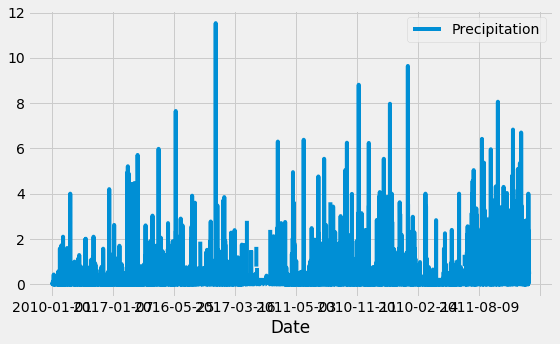

In [23]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
df = pd.DataFrame(year_prcp, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)
df.head()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(8,5))
plt.tight_layout()
plt.savefig('Images/Precipitation.png')

In [24]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


# Exploratory Station Analysis

In [25]:
# Design a query to calculate the total number of stations in the dataset
session.query(Measurement.station).group_by(Measurement.station).count()
session.query(Measurement.station).distinct().count()
               
session.query(func.count(Station.station)).all()

[(9)]

In [26]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(func.count(Measurement.station)).all()

active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
                               group_by(Measurement.station).\
                               order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
result = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                filter(Measurement.station == 'USC00519281').order_by(func.min(Measurement.tobs)).all()
result

[(54.0, 85.0, 71.66378066378067)]

In [28]:
year_temp = session.query(Measurement.tobs).\
      filter(Measurement.date >= year_ago, Measurement.station == 'USC00519281').\
      order_by(Measurement.tobs).all()

In [29]:
df1 = pd.DataFrame(year_temp, columns=['Tobs'])
df1.head()

,Tobs
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


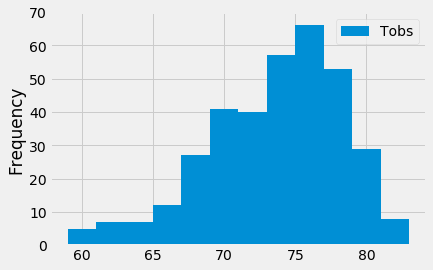

In [30]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
bins = 12
df1.plot.hist(year_temp,bins)
plt.ylim(0,70)
plt.savefig('Images/station-histogram.png')

# Close Session

In [31]:
# Close Session
session.close()